# Introduction
----

In this notebook I am going to explore the possibility of classifying methyltransferases based on the atom they act on. The classifier will be built using enzymes from the [ExPASy Enzyme database](https://ftp.expasy.org/databases/enzyme/enzyme.dat). The database should only contain experimentally verified enzymes. We start by collecting the methyl transferases from the database and counting different types of C-, O-, N- and S-methyltransferases

In [1]:
import sys
sys.path.append('../')
import os
from io_tools import fasta

# load sequences of interest
names, sequences = fasta.load('../example_data/sequences/methyltransferases/')

# download db if not downloaded already
db = '../example_data/enzyme.dat'
if not os.path.exists(db):
    expasy_url = 'https://ftp.expasy.org/databases/enzyme/enzyme.dat'
    os.system(f'wget {expasy_url} -P ../example_data/')

In [2]:
import re

expression = r"C-methyltransferase|O-methyltransferase|N-methyltransferase|S-methyltransferase"

methyltransferases_dict = {}
with open(db, 'r') as f:
    record = False
    u_ids = []
    for line in f:
        # collect enzyme names
        if line.startswith('DE') and re.search(expression, line):
            record = True
            name = line[5:-2]
        # collect uniprot ids
        if record and line.startswith('DR'):
            DR_lines = line[5:].split(';')[:-1]
            u_ids += [i.split(',')[0].replace(' ','') for i in DR_lines]
        # stop looking for enzymes when record is of
        if record == True and line.startswith('//'):
            record = False
            methyltransferases_dict[name] = u_ids
            u_ids = []           

In the following we will store the methyltransferases in a dataframe.

In [4]:
import pandas as pd

data = {'name':[],'uid':[],'type':[]}

for name in methyltransferases_dict.keys():
    if "C-methyltransferase" in name:
        n = len(methyltransferases_dict[name])
        data['name'] += [name] * n
        data['uid'] += methyltransferases_dict[name]
        data['type'] += 'C' * n
    if "O-methyltransferase" in name:
        n = len(methyltransferases_dict[name])
        data['name'] += [name] * n
        data['uid'] += methyltransferases_dict[name]
        data['type'] += 'O' * n
    if "N-methyltransferase" in name:
        n = len(methyltransferases_dict[name])
        data['name'] += [name] * n
        data['uid'] += methyltransferases_dict[name]
        data['type'] += 'N' * n
    if "S-methyltransferase" in name:
        n = len(methyltransferases_dict[name])
        data['name'] += [name] * n
        data['uid'] += methyltransferases_dict[name]
        data['type'] += 'S' * n
        
df = pd.DataFrame(data)
df

,name,uid,type
0,nicotinamide N-methyltransferase,P34254,N
1,nicotinamide N-methyltransferase,P40261,N
2,nicotinamide N-methyltransferase,O55239,N
3,nicotinamide N-methyltransferase,Q06AV1,N
4,guanidinoacetate N-methyltransferase,Q7ZXG7,N
...,...,...,...
1968,small RNA 2'-O-methyltransferase,C0IN03,O
1969,methylphosphotriester-DNA--[protein]-cysteine ...,P19219,S
1970,methylphosphotriester-DNA--[protein]-cysteine ...,P06134,S
1971,methylphosphotriester-DNA--[protein]-cysteine ...,P9WJW2,S


Next we will need the sequences of the enzymes to generate the representations. The sequences can be obtained using the uniprot mining tool. However this might take a while so I downloaded the sequences already and placed them in ```../example_data/sequences/swissprot_methyltransferases folder```. We will load in these sequence to continue. Some sequences could not be downloaded and are therefore removed from the dataframe.

In [5]:
uids, seqs = fasta.load('../example_data/sequences/swissprot_methyltransferases/')

def add_seqs(df, max_length=1500):
    """
    adds sequences to the dataframe
    """
    met_seqs = []
    for uid in df['uid'].to_list():
        #if uid in uids:
        ind = uids.index(uid)
        seq = seqs[ind]
        if len(seq) <= max_length:
            met_seqs.append(str(seq))
        else:
            to_drop = df[df['uid'] == uid].index
            # Drop the row
            df = df.drop(to_drop)
    df['sequence'] = met_seqs
    return df

df = add_seqs(df)

## Data Visualization
----
Before building a classifier we should take a look at the data first. We will look at the distribution of different sequence lengths for the individual methyltransferase classes first.

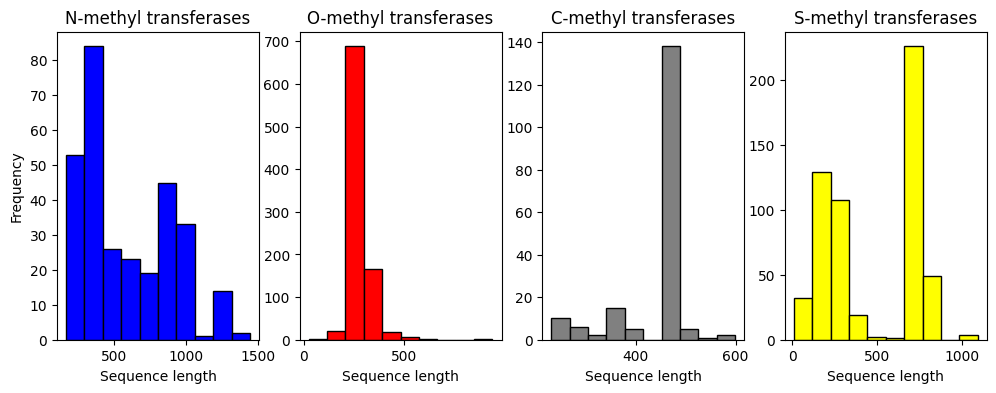

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some random data
data1 = np.array([len(x) for x in df[df['type'] == 'N']['sequence'].tolist()])
data2 = np.array([len(x) for x in df[df['type'] == 'O']['sequence'].tolist()])
data3 = np.array([len(x) for x in df[df['type'] == 'C']['sequence'].tolist()])
data4 = np.array([len(x) for x in df[df['type'] == 'S']['sequence'].tolist()])

# Set up the subplots
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

# Plot the first histogram
axes[0].hist(data1, bins=10, color='blue', edgecolor='black')
axes[0].set_xlabel('Sequence length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('N-methyl transferases')

# Plot the second histogram
axes[1].hist(data2, bins=10, color='red', edgecolor='black')
axes[1].set_xlabel('Sequence length')
axes[1].set_title('O-methyl transferases')

# Plot the third histogram
axes[2].hist(data3, bins=10, color='grey', edgecolor='black')
axes[2].set_xlabel('Sequence length')
axes[2].set_title('C-methyl transferases')

# Plot the fourth histogram
axes[3].hist(data4, bins=10, color='yellow', edgecolor='black')
axes[3].set_xlabel('Sequence length')
axes[3].set_title('S-methyl transferases')

# Show the plot
plt.show()

## Visualizing the representations
----
In the next step I already pre generated the representations for the sequences using the embedd extraction tool ```../extraction/embedd.py```. The generation of representations might take a while depending on you machine. 

The representations are stored in ```../example_data/representations/methyltransferases/```.

We will visualize the representations by projecting them onto the first two principal components. Using PCA we can get an idea of how well seperated the samples might be. Although, keep in mind, this is a 2 dimensional projection, reflecting the variance of a way higher dimensional space. Nonetheless this is a good starting point.

In [7]:
import torch
from io_tools import representations

rep_ids, reps = representations.load('../example_data/representations/methyltransferases/')

def add_reps(df):
    """
    adds representations to the dataframe
    """
    rs = []
    for uid in df['uid'].to_list():
        if uid in rep_ids:
            ind = rep_ids.index(uid)
            r = reps[ind]
            rs.append(r)
        else:
            to_drop = df[df['uid'] == uid].index
            # Drop the row
            df = df.drop(to_drop)
    
    df['representation'] = rs
    return df

df = add_reps(df)

In [8]:
from sklearn.decomposition import PCA
import numpy as np

Xs = torch.stack(df['representation'].to_list(), dim=0).numpy()

labels = {'O':0, 'C':1, 'N':2, 'S':3}
Ys = [labels[x] for x in df['type'].to_list()]

num_pca_components = 60
pca = PCA(num_pca_components)
Xs_pca = pca.fit_transform(Xs)

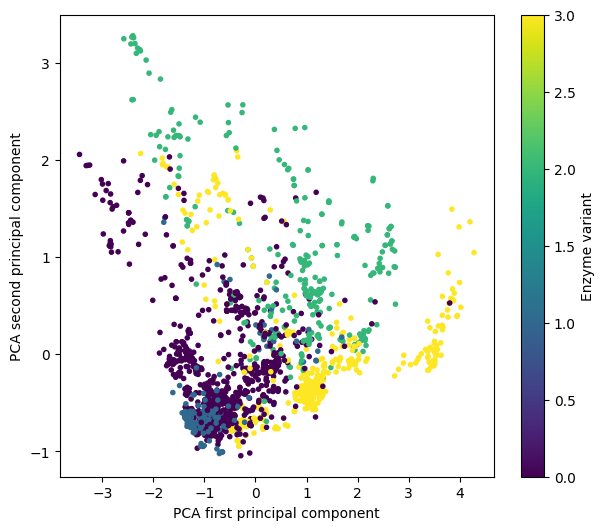

In [9]:
import matplotlib.pyplot as plt

fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_pca[:,0], Xs_pca[:,1], c=Ys, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Enzyme variant')

## Classification
---

The PCA plot already hints that the sequences could be separated quite well into different classes. In the following we are now building classifiers using entire representations. We are going to compare nearest neighbor methods (KNN), with support vector machines (SVM), and random forrests (RF).

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xs, Ys, test_size=0.2, random_state=42)

# Train the kNN classifier
optimal_n = 0
optimal_acc = 0
for n in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)

    # Evaluate the classifier on the test data
    accuracy = knn.score(X_test, y_test)
    if accuracy > optimal_acc:
        optimal_n = n
        optimal_acc = accuracy
        
knn = KNeighborsClassifier(n_neighbors=optimal_n)
knn.fit(X_train, y_train)

# Evaluate the classifier on the test data
accuracy = knn.score(X_test, y_test)        
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("optimal n:", optimal_n)

Accuracy: 97.70%
optimal n: 1


In [11]:
from sklearn.svm import SVC

# Train the SVM classifier
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Evaluate the classifier on the test data
accuracy = svm.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 97.96%


In [12]:
from sklearn.ensemble import RandomForestClassifier

# Train the random forest classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

# Evaluate the classifier on the test data
accuracy = rf.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 96.68%
